# Self-Balancing Scooter Control

![](images/self-balancing-scooter.png)

> A self-balancing scooter [...] is a self-balancing personal transporter consisting of two motorized wheels connected to a pair of articulated pads on which the rider places their feet. The rider controls the speed by leaning forward or backward, and direction of travel by twisting the pads.
> 
> Source: <https://en.wikipedia.org/wiki/Self-balancing_scooter>

### Python Dependencies

In [27]:
import numpy as np
from numpy.linalg import *

from scipy.linalg import *
from scipy.integrate import *
from scipy.signal import *

import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Polygon

Step 1 - Scooter Planar Model
================================

### Introduction

We consider a simple model of a self-balancing scooter evolving in the plane. It is mainly made of

  - The frame that contains the two articulated pads; from above, each pad essentially look like a triangle (one vertice in the center of the frame, one vertice at each extremity of the wheel).

  - Two fixed wheels (their orientation with respect to the frame does not change). 
    They are parallel and located at opposite ends of the frame. 
    
Let $(0, e_x, e_y)$ be a direct orthonormal frame of the plane. We denote 

  - $(x, y)$ the coordinates of the wheel axis center in the orthonormal and 
  - $\theta$ the angle of the wheels direction with respect to vector $e_x$ ; with $\theta = 0$ when the front of the scooter faces the right ($e_x$) and $\theta = \pi/2$ when it faces upwards ($e_y$).

  - $\phi_l$ and $\phi_r$ the rotation angles of the left and right wheel respectively ; by convention, when these angles increase, the scooter moves forward.

### Parameter Definition

From now on, we assume that the seat frame length is $\ell = 50 \mbox{ cm}$ and the wheel radius is $r = 12.5 \mbox{ cm}$.

🧩 Define the corresponding Python variables `l` and `r` (express every length in meters, and more generally in the sequel, always use the [international standard of units](https://en.wikipedia.org/wiki/SI_derived_unit)) for numerical values. 

In [28]:
l = 0.5
r = 0.125

### Graphical Representation

🧩 Implement a function `draw_scooter` with arguments `x`, `y` and `theta` that draws a simple geometric model of the wheelchair (with a red frame and black fixed wheels) in the plane (top view) for arbitrary values of $(x, y)$ and $\theta$. Use a green circle marker 50 cm in of the frame to indicate which way is forward.

🗝️ **Hint.** Use the function `plot` of `matplotlib.pyplot`.

In [29]:
def rotate_point(x, y, theta, x_center, y_center):
# Calculate the rotated coordinates
    x_rotated = (x - x_center) * np.cos(theta) - (y - y_center) * np.sin(theta) + x_center
    y_rotated = (x - x_center) * np.sin(theta) + (y - y_center) * np.cos(theta) + y_center
    return (x_rotated, y_rotated)

def draw_hoverboard(x, y, theta) :
  half_side = l/2
  wheel_thickness = 0.05

  up_tr_coord1 = rotate_point(x - half_side/2, y + half_side, theta, x, y)
  up_tr_coord2 = rotate_point(x + half_side/2, y + half_side, theta, x, y)
  down_tr_coord1 = rotate_point(x - half_side/2, y - half_side, theta, x, y)
  down_tr_coord2 = rotate_point(x + half_side/2, y - half_side, theta, x, y)

  # Define the coordinates of the upper triangle vertices
  upper_triangle_coords = [up_tr_coord1, up_tr_coord2, (x, y)]
  lower_triangle_coords = [down_tr_coord1, down_tr_coord2, (x, y)]

  # Create upper triangle
  upper_triangle = Polygon(upper_triangle_coords, closed=True, fill=True, color='blue')  # You can change the color
  lower_triangle = Polygon(lower_triangle_coords, closed=True, fill=True, color='blue')  # You can change the color

  # Add the upper triangle to the axes
  ax.add_patch(upper_triangle)
  ax.add_patch(lower_triangle)


  top_bar_coord1 = rotate_point(x - half_side/2, y + half_side, theta, x, y)
  top_bar_coord2 = rotate_point(x - half_side/2, y + half_side - wheel_thickness, theta, x, y)
  top_bar_coord3 = rotate_point(x + half_side/2, y + half_side - wheel_thickness, theta, x, y)
  top_bar_coord4 = rotate_point(x + half_side/2, y + half_side, theta, x, y)
  bottom_bar_coord1 = rotate_point(x - half_side/2, y - half_side, theta, x, y)
  bottom_bar_coord2 = rotate_point(x - half_side/2, y - half_side + wheel_thickness, theta, x, y)
  bottom_bar_coord3 = rotate_point(x + half_side/2, y - half_side + wheel_thickness, theta, x, y)
  bottom_bar_coord4 = rotate_point(x + half_side/2, y - half_side, theta, x, y)

  top_bar_coords = [top_bar_coord1, top_bar_coord2, top_bar_coord3, top_bar_coord4]
  bottom_bar_coords = [bottom_bar_coord1, bottom_bar_coord2, bottom_bar_coord3, bottom_bar_coord4]

  # Create top black bar
  top_bar = Polygon(top_bar_coords, closed=True, fill=True, color='black')
  bottom_bar = Polygon(bottom_bar_coords, closed=True, fill=True, color='black')

  # Add the top black bar to the axes
  ax.add_patch(top_bar)
  ax.add_patch(bottom_bar)

  # Add circle
  circle_center = (x + 0.5, y)  # Center coordinates (x, y)
  center_rotated = rotate_point(circle_center[0], circle_center[1], theta, x, y)
  radius = 0.03  # Radius of the circle

  circle = Circle(center_rotated, radius, fill=True, color='green')
  ax.add_patch(circle)

🧩 Represent the wheelchair when $(x, y, \theta) = (0, 0, 0), (2, 2, \pi/2), (0, 4, \pi), (-2, 2, 3\pi/2)$.

🗝️ **Hint.** Use the following `draw_arena` function beforehand.

In [30]:
def draw_arena(xmin, xmax, ymin, ymax):
    wh_ratio = (xmax - xmin) / (ymax - ymin)
    figsize = fig_width, fig_height = 16, 16 / wh_ratio
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_aspect(1)
    ax.set_xticks(np.arange(xmin, xmax + 1, 1))
    ax.set_yticks(np.arange(ymin, ymax + 1, 1))
    ax.grid(True)
    return fig, ax

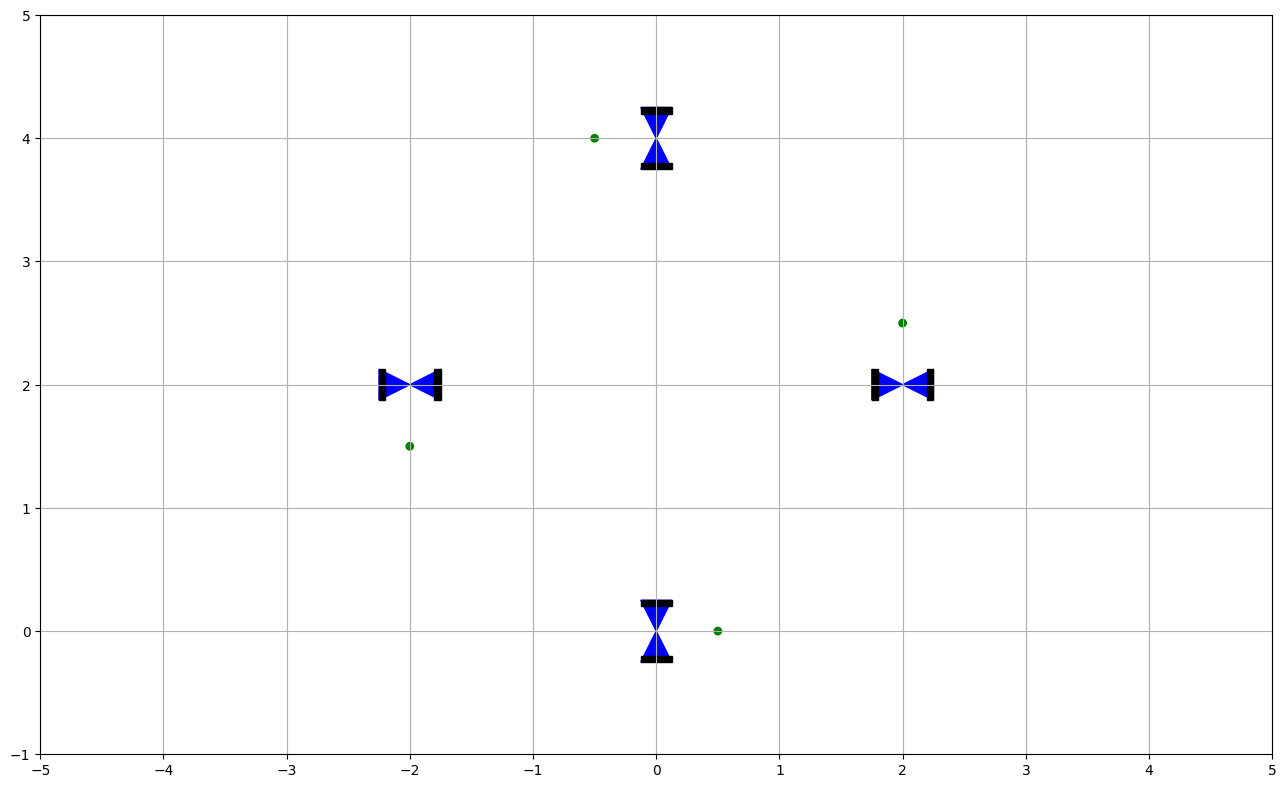

In [31]:
fig, ax = draw_arena(-5, 5, -1, 5)
draw_hoverboard(0, 0, 0)
draw_hoverboard(2, 2, np.pi/2)
draw_hoverboard(0, 4, np.pi)
draw_hoverboard(-2, 2, 3*np.pi/2)
plt.show()

### Kinematic Modeling

We assume that we can control the wheels angular velocities $\omega_l = \dot{\phi}_l$ and $\omega_r = \dot{\phi}_r$ (this is a *kinematic* model of the wheelchair).
We also assume that the wheelchair fixed wheels roll without slipping. 

🧩 Establish the differential equations that relate $\dot{x}$,
$\dot{y}$ and $\dot{\theta}$ with $\omega_l$ and $\omega_r$.

**TODO**

In [32]:
# Differential equations
w_l = 0
w_r = 0
theta = 0

v = r * (w_l + w_r) / 2
theta_point = r * (w_r - w_l) / l

x_point = v * np.cos(theta)
y_point = v * np.sin(theta)

### Analysis

🧩 Show that if $\omega_l$ and $\omega_r$ are continuously differentiable functions of $(x, y, \theta)$ (which includes the case of constant inputs), this system is well-posed.

Le système qui décrit le mouvement d'un robot à deux roues est bien posé lorsque les vitesses angulaires $ \omega_l $ et $ \omega_r $ sont des fonctions continûment différentiables de $ x $, $ y $, et $ \theta $. Cette différentiabilité assure que les fonctions sont continues et satisfont à la condition de Lipschitz localement, ce qui est nécessaire pour appliquer le théorème de Cauchy-Lipschitz. Ce théorème garantit l'existence et l'unicité des solutions pour toutes conditions initiales données. De plus, la dépendance continue des solutions vis-à-vis des conditions initiales confirme que le système répond de manière prévisible aux variations des conditions de départ. Ces caractéristiques confirment que le système est mathématiquement bien posé, satisfaisant ainsi les critères d'existence, d'unicité, et de dépendance continue des solutions par rapport aux conditions initiales.

**TODO**

🧩 Show that if $\omega_l$ and $\omega_r$ are constants, the maximal solution associated to any initial state is global. Is is still true of $\omega_l$ and $\omega_r$ are arbitrary continuously differentiable functions of $(x, y, \theta)$ ?

Cas 1:
Dans le cas où $ \omega_l $ et $ \omega_r $, les vitesses angulaires des roues d'un robot à deux roues, sont constantes, les solutions maximales des équations différentielles du mouvement sont globales. La constance de $ \dot{\theta} = \frac{r}{l} (\omega_r - \omega_l) $ entraîne une variation linéaire de $ \theta(t) = \theta_0 + \frac{r}{l} (\omega_r - \omega_l)t $, sans introduire de singularités ni de limites. Les vitesses $ \dot{x} = \frac{r}{2} (\omega_l + \omega_r) \cos(\theta) $ et $ \dot{y} = \frac{r}{2} (\omega_l + \omega_r) \sin(\theta) $ restent également bornées du fait que $ \cos(\theta) $ et $ \sin(\theta) $ oscillent périodiquement entre -1 et 1. De plus, les conditions de continuité et de Lipschitz nécessaires pour l'application du théorème de Cauchy-Lipschitz sont satisfaites, assurant ainsi l'existence, l'unicité et la prolongation continue des solutions sur tout l'intervalle $ t $ de $ -\infty $ à $ \infty $. Par conséquent, les solutions du système sont globales et ne présentent aucun risque de divergence ou d'explosion en un temps fini, étant valides pour tout intervalle de temps.
Cas 2:


**TODO**

### Vector Field

In the sequel, `omega` is a function that computes the input vector $\omega := (\omega_l, \omega_r)$ given the time $t$ and $(x, y, \theta)$ (thus, it may depend on the time and/or on the system state if needed). For example:

In [35]:
def omega(t, xytheta):
    omega_l = (1 - l/4) * pi / r
    omega_r = (1 + l/4) * pi / r
    return array([omega_l, omega_r])

🧩 Implement a function `fun(t, xytheta)` that computes $(\dot{x}, \dot{y}, \dot{\theta})$ given the time $t$ and $(x,y,\theta)$ (and implicitly the inputs $\omega$ computed by the function `omega`).

In [36]:
def fun(t, xytheta):
    x, y, theta = xytheta
    omega_l, omega_r = omega(t, xytheta)
    x_point = r * 0.5 * (omega_l + omega_r) * cos(theta)
    y_point = r * 0.5 * (omega_l + omega_r) * sin(theta)
    theta_point = r * (omega_r - omega_l) / l
    return array([x_point, y_point, theta_point])

### Simulation Setup


   

In [37]:
xytheta0 = [0.0, 0.0, 0.0]
time_span = [0, 4]

# Solve the differential equations
solution = solve_ivp(fun=fun, t_span=time_span, y0=xytheta0, dense_output = True)

In [38]:
time = solution["t"]
x = solution["y"][0]
y = solution["y"][1]
theta = solution["y"][2]
sol = solution["sol"]

🧩 Use the simulation results to draw the graphs of $x(t)$, $y(t)$ and $\theta(t)$.

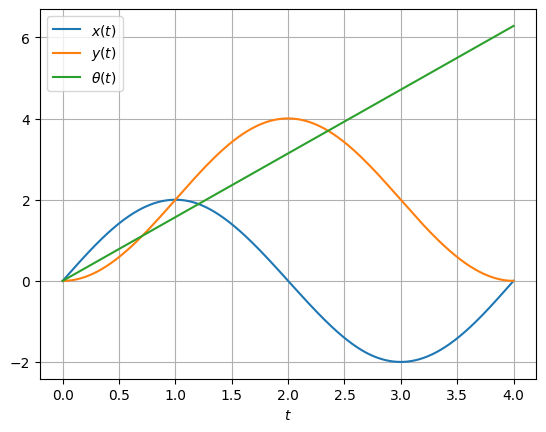

In [42]:
plt.figure()
t = np.linspace(0, 4, 1000)
plt.plot(t, sol(t)[0], "-", label="$x(t)$")
plt.plot(t, sol(t)[1], "-", label="$y(t)$")
plt.plot(t, sol(t)[2], "-", label="$ θ(t)$")
plt.xlabel("$t$")
plt.grid()
plt.legend()

🧩 Use the simulation results to display the robot location every 0.5 second.

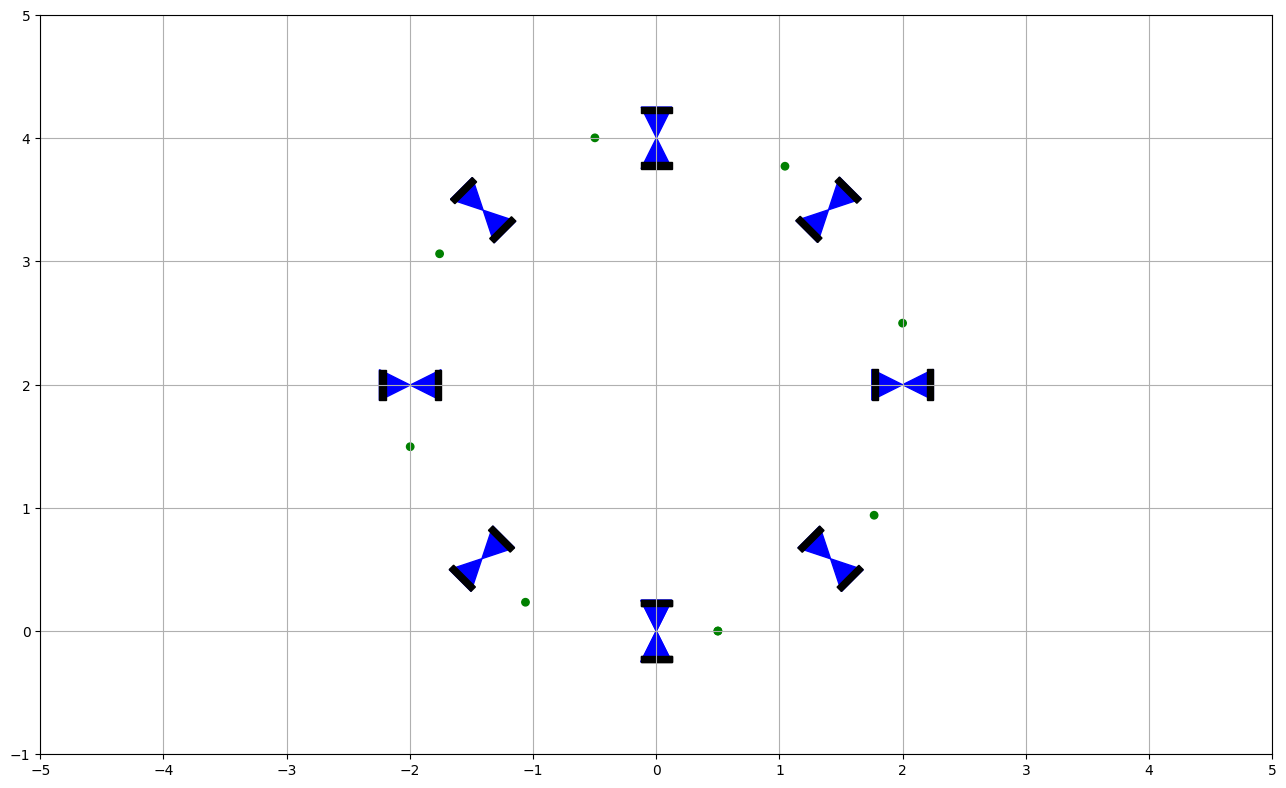

In [43]:
fig, ax = draw_arena(-5, 5, -1, 5)
timespan = [i*0.5 for i in range(9)]
for t in timespan:
    draw_hoverboard(sol(t)[0],sol(t)[1],sol(t)[2])
plt.show()

🧩 What should be the analytical expression of $x(t)$, $y(t)$ and $\theta(t)$? 

Pour $\omega_p = \left(1 - \frac{l}{4}\right)\frac{\pi}{r}$ et $\omega_r = \left(1 + \frac{l}{4}\right)\frac{\pi}{r}$

$
\begin{aligned}
&\text{On a} \\
&\left\{
\begin{array}{ll}
\dot{x} = V \cos (\theta) = \frac{r}{2}(\omega_{l} + \omega_{r}) \cos (\theta) \\
\dot{y} = V \sin (\theta) = \frac{r}{2}(\omega_{l} + \omega_{r}) \sin (\theta)
\end{array}
\right.
\end{aligned}
$

$
\begin{aligned}
&\text{On injecte les expressions de vitesses angulaires :} \\
&\left\{
\begin{array}{ll}
\dot{x} = \frac{2 \pi}{r}\ \frac{r}{2} \cos (\theta)  = \pi \cos \theta \\
\dot{y} = \frac{2 \pi}{r} \frac{r}{2} \sin (\theta) = \pi \sin \theta \\
\dot{\theta} = \frac{v_p}{l}(\omega_r - \omega_l) = \frac{v}{l} \left(\frac{l \pi}{r}\right) = \frac{\pi}{2}
\end{array}
\right.
\end{aligned}
$

$
\text{Donc, on intègre theta point :}
$

$
\begin{aligned}
\left\{
\begin{array}{ll}
\dot{\theta} = \frac{\pi}{2} \implies \theta = \frac{\pi}{2} t \hspace{1cm} (\theta(0) = 0) \\
\dot{x}(t) = \pi \cos \left(\frac{\pi}{2} t\right)  \\
\dot{y}(t) = \pi \cos \left(\frac{\pi}{2} t\right)
\end{array}
\right.
\end{aligned}
$


$
\text{Donc, en intégrant par rapport au temps et en prenant en considération les conditions initiales.}\\
\begin{aligned}
\left\{
\begin{array}{ll}
x(t) = 2 \sin \left(\frac{\pi}{2} t\right) \hspace{1cm} (x(0) = 0)\\
y(t) = -2 \cos \left(\frac{\pi}{2} t\right) + 2 \hspace{1cm} (y(0) = 0) \\
θ(t)=\frac{\pi}{2}t
\end{array}
\right.
\end{aligned}
$

**TODO**

🧩 Do you experimental results match the theoretical results ? Draw the curves of the simulation error at time $t$ for $x$, $y$ and $\theta$.

In [46]:
# Theoretical expressions
def x(t):
  return 2 * np.sin(np.pi*t/2)
def y(t):
  return -2 * np.cos(np.pi*t/2) + 2
def theta(t):
  return np.pi*t/2

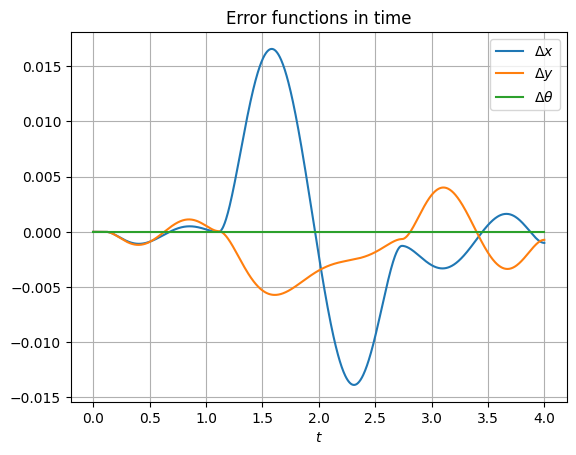

In [48]:
# Error functions
plt.figure()
t = linspace(0, 4, 1000)
plt.plot(t, x(t) - sol(t)[0], "-", label="$\Delta x$")
plt.plot(t, y(t) - sol(t)[1], "-", label="$\Delta y$")
plt.plot(t, theta(t) - sol(t)[2], "-", label="$\Delta θ$")
plt.xlabel("$t$")
plt.title("Error functions in time")
plt.grid()
plt.legend()

🧩 If needed, adjust the simulation parameters the simulated position error is less than $1\, \mathrm{ mm}$. 

In [49]:
# Adjusting relative tolerance () and solving the differential equation
solution = solve_ivp(fun=fun, t_span=time_span, y0=xytheta0, dense_output = True, rtol=10**-4)
sol = solution["sol"]

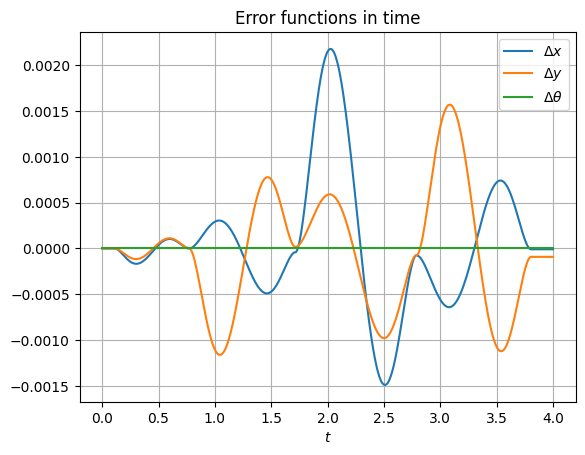

In [50]:
# Error function with adjusted relative tolerance
plt.figure()
plt.t = linspace(0, 4, 1000)
plt.plot(t, x(t) - sol(t)[0], "-", label="$\Delta x$")
plt.plot(t, y(t) - sol(t)[1], "-", label="$\Delta y$")
plt.plot(t, theta(t) - sol(t)[2], "-", label="$\Delta θ$")
plt.xlabel("$t$")
plt.title("Error functions in time")
plt.grid()
plt.legend()